In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from ydata_profiling import ProfileReport
import src.dataHandling.cleaningUtils as clean
import os
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance


In [2]:
def drop_irrelevant(df: pd.DataFrame) -> pd.DataFrame:
    """
    drops columns which are irrelevant for the model (mostly ids)
    :param df: pd.DataFrame
    :return: None
    """
    irrelevant_cols = []
    general_irrelevant = ['gameDuration', 'gameCreation', 'gameVersion', 'mapId', 'queueId', 'patch', 'seasonId',
                          'platformId']
    irrelevant_cols.extend(general_irrelevant)
    participant_irrelevant = ['win', 'lp']
    for i in range(1, 11):
        for col in participant_irrelevant:
            irrelevant_cols.append(f'participant{i}_{col}')
    df_new = df.drop(columns=irrelevant_cols)
    return df_new

In [3]:
try:
    with open("data/static_16_12_23/raw/static_full.pkl", "rb") as f:
        df = pickle.load(f)
except FileNotFoundError:
    os.chdir('../')
    with open("data/static_16_12_23/raw/static_full.pkl", "rb") as f:
        df = pickle.load(f)
df = clean.drop_wrong_data(df)
df.reset_index(drop=True, inplace=True)
df = clean.fix_rank(df)
df = clean.calc_winrate(df)
df = clean.fix_teamId(df)
df = clean.convert_booleans(df)
df = clean.convert_lastPlayTime(df)
df = clean.convert_championTier(df)
df = clean.get_winning_team(df)  # this has to be the last step where a column is inserted
df = clean.drop_wrong_teamIds(df)
df = drop_irrelevant(df)
df = clean.drop_missing(df)
assert df.columns[-1] == 'label'
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1],
                                                    df.iloc[:, -1],
                                                    test_size=0.1,
                                                    random_state=42,
                                                    shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.1,
                                                  random_state=42,
                                                  shuffle=True)

found 51361 rows
dropped wrong mapId
dropped wrong queueId
dropped wrong gameDuration
dropped wrong seasonId
dropped wrong gameVersion
dropped wrong patch
dropped 0 wrong rows
dropped 78 rows because of wrong teamIds
dropped 12710 rows


In [4]:
len(df)

38573

In [5]:
df.head()

,participant1_level,participant1_champion_championNumber,participant1_champion_infoAttack,participant1_champion_infoDefense,participant1_champion_infoMagic,participant1_champion_infoDifficulty,participant1_champion_tier,participant1_champion_win_rate,participant1_champion_pick_rate,participant1_champion_ban_rate,...,participant2_winrate,participant3_winrate,participant4_winrate,participant5_winrate,participant6_winrate,participant7_winrate,participant8_winrate,participant9_winrate,participant10_winrate,label
0,988,83,6,6,4,6,2,49.86,2.2,2.2,...,0.800000,0.544262,0.666667,0.512315,0.630631,0.524548,0.511364,0.522696,0.550562,1
1,121,150,6,5,5,8,2,49.75,0.4,0.4,...,0.833333,0.539648,0.530172,0.576923,0.534060,0.537559,0.527559,0.588235,0.511971,1
2,739,164,8,6,3,4,5,53.02,3.0,3.0,...,0.000000,0.513369,0.588235,0.510145,0.600000,0.537559,0.539648,0.527950,0.500000,1
3,841,54,5,9,7,2,5,51.50,15.2,15.2,...,0.541528,0.524000,0.653846,0.511971,0.506912,0.553476,0.525275,0.468750,0.508163,1
4,766,24,7,5,7,5,0,48.49,16.8,16.8,...,0.517751,0.536443,0.504360,0.562264,0.368421,0.666667,0.428571,0.583333,0.622449,0


In [6]:
kda_columns = ['participant1_champion_kda', 'participant2_champion_kda', 'participant3_champion_kda',
               'participant4_champion_kda', 'participant5_champion_kda', 'participant6_champion_kda',
               'participant7_champion_kda', 'participant8_champion_kda', 'participant9_champion_kda',
               'participant10_champion_kda']


In [7]:
corr_pearson = df.corr()
corr_pearson_target = abs(corr_pearson["label"])
relevant_features = corr_pearson_target[corr_pearson_target > 0.05]
corr_pearson_target.sort_values(ascending=False)


label                     1.000000
participant4_kda          0.150714
participant7_kda          0.144979
participant9_kda          0.144269
participant5_kda          0.142817
                            ...   
participant8_teamId            NaN
participant9_inactive          NaN
participant9_teamId            NaN
participant10_inactive         NaN
participant10_teamId           NaN
Name: label, Length: 321, dtype: float64

In [8]:
from scipy.stats import pearsonr

results = []
for column in df.columns:
    if column != 'label':
        corr, pval = pearsonr(df[column], df['label'])
        results.append({'Feature': column, 'Correlation': corr, 'P-Value': pval})

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Correlation', ascending=False, key=abs)

An input array is constant; the correlation coefficient is not defined.


In [9]:
results_df

,Feature,Correlation,P-Value
115,participant4_kda,-0.150714,9.719834e-195
208,participant7_kda,0.144979,3.349315e-180
270,participant9_kda,0.144269,1.918576e-178
146,participant5_kda,-0.142817,7.112282e-175
53,participant2_kda,-0.141945,9.490762e-173
...,...,...,...
247,participant8_teamId,NaN,NaN
262,participant9_inactive,NaN,NaN
278,participant9_teamId,NaN,NaN
293,participant10_inactive,NaN,NaN


In [10]:
results_df['Correlation'] = results_df['Correlation'].abs().sort_values(ascending=False)

In [13]:
results_df['category'] = results_df['Feature'].str.extract(r'(participant\d+)_(\w+)', expand=False)[1]
results_df

,Feature,Correlation,P-Value,category
115,participant4_kda,0.150714,9.719834e-195,kda
208,participant7_kda,0.144979,3.349315e-180,kda
270,participant9_kda,0.144269,1.918576e-178,kda
146,participant5_kda,0.142817,7.112282e-175,kda
53,participant2_kda,0.141945,9.490762e-173,kda
...,...,...,...,...
247,participant8_teamId,NaN,NaN,teamId
262,participant9_inactive,NaN,NaN,inactive
278,participant9_teamId,NaN,NaN,teamId
293,participant10_inactive,NaN,NaN,inactive


In [14]:
average_per_category = results_df.groupby('category').mean()
average_per_category.sort_values(by='Correlation', ascending=False)

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


,Correlation,P-Value
category,,
kda,0.135445,1.767897e-114
deaths,0.095047,1.310247e-61
assists,0.085038,3.136772e-38
gold,0.064535,1.661277e-15
kills,0.060383,2.637668e-03
damage,0.040846,7.302930e-02
championLevel,0.032280,2.902850e-05
winrate,0.029807,8.996907e-08
cs,0.029541,3.851429e-03


In [15]:
bst = xgb.XGBClassifier(n_estimators=100, max_depth=30, learning_rate=0.1, objective='binary:logistic', device='cpu')

In [16]:
bst.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [17]:
bst.score(X_test, y_test)

0.6944012441679627

In [18]:
feature_important = bst.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by="score", ascending=False)
data

,score
participant4_kda,1189.0
participant5_kda,1154.0
participant1_kda,1139.0
participant6_kda,1135.0
participant2_kda,1103.0
...,...
participant10_veteran,32.0
participant7_veteran,32.0
participant4_hotStreak,30.0
participant6_veteran,29.0


In [22]:
data_reset = data.reset_index()
data_reset['category'] = data_reset['index'].str.extract(r'(participant\d+)_(\w+)', expand=False)[1]
average_per_category = data_reset.groupby('category').mean()
average_per_category.sort_values(by='score', ascending=False)

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


,score
category,
kda,1100.9
winrate,727.7
level,720.5
championPoints,714.1
cs,663.5
assists,658.4
leaguePoints,620.3
gold,620.2
damage,608.1


In [23]:
X_train.columns.values

array(['participant1_level', 'participant1_champion_championNumber',
       'participant1_champion_infoAttack',
       'participant1_champion_infoDefense',
       'participant1_champion_infoMagic',
       'participant1_champion_infoDifficulty',
       'participant1_champion_tier', 'participant1_champion_win_rate',
       'participant1_champion_pick_rate',
       'participant1_champion_ban_rate', 'participant1_champion_matches',
       'participant1_tier', 'participant1_leaguePoints',
       'participant1_veteran', 'participant1_inactive',
       'participant1_freshBlood', 'participant1_hotStreak',
       'participant1_lastPlayTime', 'participant1_championLevel',
       'participant1_championPoints',
       'participant1_championPointsSinceLastLevel',
       'participant1_tokensEarned', 'participant1_kda',
       'participant1_kills', 'participant1_deaths',
       'participant1_assists', 'participant1_maxKills', 'participant1_cs',
       'participant1_damage', 'participant1_gold', 'part

In [24]:
sortedidx = bst.feature_importances_.argsort()
X_train.columns.values[sortedidx]

array(['participant2_inactive', 'participant8_champion_ban_rate',
       'participant1_teamId', 'participant7_teamId',
       'participant2_champion_ban_rate', 'participant7_inactive',
       'participant7_champion_ban_rate', 'participant6_teamId',
       'participant6_inactive', 'participant8_inactive',
       'participant6_champion_ban_rate', 'participant5_inactive',
       'participant2_teamId', 'participant5_champion_ban_rate',
       'participant3_champion_ban_rate', 'participant3_inactive',
       'participant4_teamId', 'participant4_inactive',
       'participant4_champion_ban_rate', 'participant5_teamId',
       'participant8_teamId', 'participant3_teamId',
       'participant9_champion_ban_rate', 'participant10_teamId',
       'participant10_inactive', 'participant10_champion_ban_rate',
       'participant9_teamId', 'participant1_inactive',
       'participant9_inactive', 'participant1_champion_ban_rate',
       'participant1_freshBlood', 'participant8_freshBlood',
       'par

In [25]:
bst.feature_importances_[sortedidx]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00179417, 0.00218013, 0.00233739, 0.00234375, 0.0024199 ,
       0.00242148, 0.00246236, 0.00249976, 0.00250372, 0.00256248,
       0.00256379, 0.00257375, 0.00258597, 0.00259579, 0.00259665,
       0.00259904, 0.00263605, 0.00266189, 0.00268032, 0.0026823 ,
       0.0026973 , 0.00270829, 0.00272788, 0.00273822, 0.00275465,
       0.00276605, 0.00276655, 0.00276717, 0.00277024, 0.00279978,
       0.00280046, 0.00280198, 0.00282083, 0.00282825, 0.00283284,
       0.0028374 , 0.00283997, 0.00284213, 0.00285294, 0.00285662,
       0.0028582 , 0.002863  , 0.00287009, 0.00287384, 0.00288

FixedFormatter should only be used together with FixedLocator


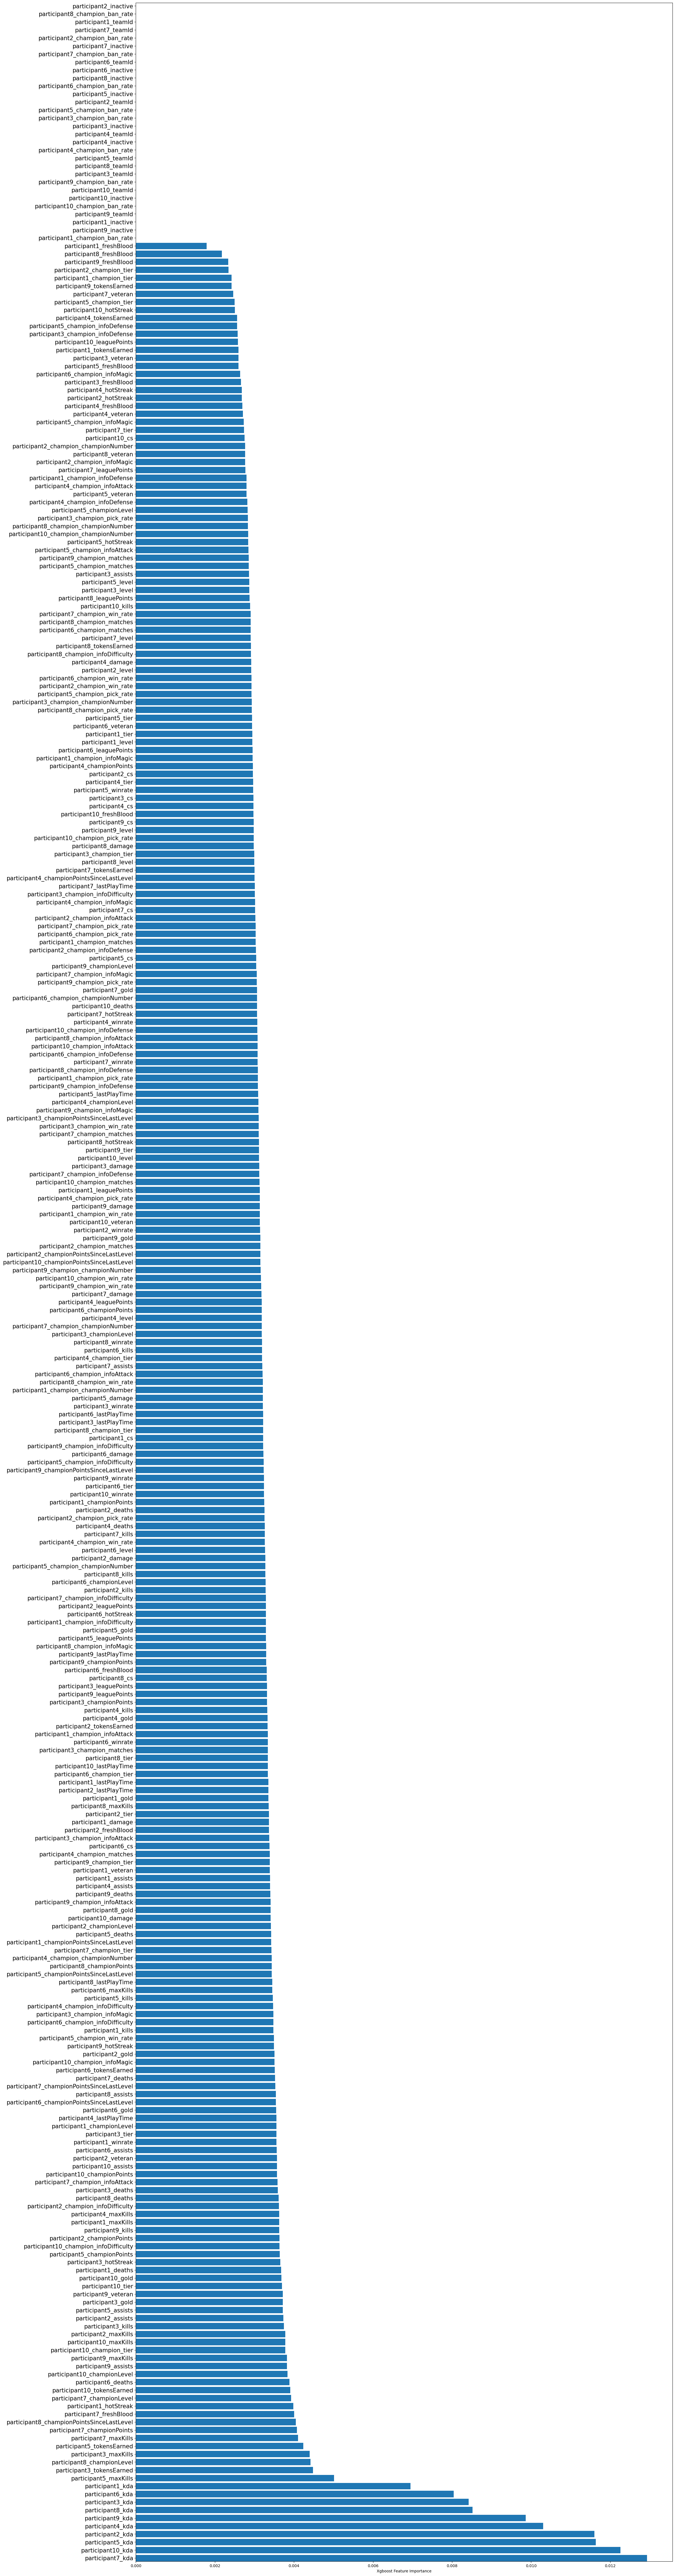

In [29]:
sorted_idx = bst.feature_importances_.argsort()[::-1]
fig, ax = plt.subplots(figsize=(25, 120))
ax.set_yticklabels(X_train.columns.values[sorted_idx], fontsize=15)
ax.margins(y=0)
plt.barh(X_train.columns.values[sorted_idx], bst.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.show()

In [30]:
X_train.columns.values[sorted_idx].tolist()[0:20]

['participant7_kda',
 'participant10_kda',
 'participant5_kda',
 'participant2_kda',
 'participant4_kda',
 'participant9_kda',
 'participant8_kda',
 'participant3_kda',
 'participant6_kda',
 'participant1_kda',
 'participant5_maxKills',
 'participant3_tokensEarned',
 'participant8_championLevel',
 'participant3_maxKills',
 'participant5_tokensEarned',
 'participant7_maxKills',
 'participant7_championPoints',
 'participant8_championPointsSinceLastLevel',
 'participant7_freshBlood',
 'participant1_hotStreak']

In [31]:
bst2 = xgb.XGBClassifier(n_estimators=100, max_depth=80, learning_rate=0.1, objective='binary:logistic', device='cpu')
bst2.fit(X_train[X_train.columns.values[sorted_idx].tolist()], y_train)
bst2.score(X_test[X_train.columns.values[sorted_idx].tolist()], y_test)

0.7042509072058061

In [29]:
num_round = 100
param = {
    "eta": 0.05,
    "max_depth": 10,
    "tree_method": "hist",
    "device": "cuda",
}

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.values.tolist())
model = xgb.train(param, dtrain, num_round)

In [ ]:
model.set_param({"device": "cuda"})
shap_values = model.predict(dtrain, pred_contribs=True)

In [ ]:
shap_interaction_values = model.predict(dtrain, pred_interactions=True)

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

In [ ]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [ ]:
shap.force_plot(
    explainer.expected_value,
    shap_values[0, :],
    X_train.to_numpy()[0, :],
    feature_names=X_train.columns.values.tolist(),
    matplotlib=True,
)

In [ ]:
perm_importance = permutation_importance(bst, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(15, 105))
ax.set_yticklabels(X_train.columns.values[sorted_idx], fontsize=10)
ax.margins(y=0)
plt.barh(X_train.columns.values[sorted_idx], bst.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.show()

In [ ]:
X_train[X_train.columns.values[sorted_idx][-1]]